# Supervised

This notebook trains a classification model with all the labeled images from data_augmentation.ipynb

### Imports

In [27]:
import os
import sys
import itertools
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers


from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score

from tensorflow.keras import regularizers
from itertools import product

### Definitions

In [28]:
sys.path.insert(0, "../../")
from config import RESULTS_PATH, CROPPED_PATH, MODELS_PATH

# Paths
TRAIN_PATH = os.path.join(CROPPED_PATH, 'ina', 'labeled_images', 'VGG16_kmeans_v0', 'train')
VALIDATION_PATH = os.path.join(CROPPED_PATH, 'ina', 'labeled_images', 'VGG16_kmeans_v0', 'validation')
TEST_PATH = os.path.join(CROPPED_PATH, 'ina', 'labeled_images', 'test')
ENCODER_PATH = os.path.join(MODELS_PATH, 'encoder', 'encoder_SSIM_MAE_Bparams.keras')
RESULT_PATH = os.path.join(RESULTS_PATH, 'results_encoder_SSIM+MAE.xlsx')
MODEL_PATH = os.path.join(MODELS_PATH, 'supervised')

# Configuration
SHAPE = (128,128,1)
BATCH_SIZE = 32
TRAIN_ENCODER = False
COLOR_MODE="grayscale"
results = []


### Functions

In [29]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)


def plot_conf_matrix(model, generator, titulo='Confusion matrix'):
    ### RETRIVE TEST LABEL FROM GENERATOR ###
    test_num = sum(1 for _ in generator)
    label_test = []
    pred_test = []

    for i, batch in enumerate(generator):
        X, y = batch
        label_test.append(y.numpy())
        predictions = model.predict(X)
        predictions = tf.nn.softmax(predictions, axis=-1)
        pred_test.append(predictions)


    label_test = np.argmax(np.vstack(label_test), axis=1)


    ### COMPUTE PREDICTIONS ON TEST DATA ###
    pred_test = np.argmax(np.vstack(pred_test), axis=1)
    accuracy=accuracy_score(label_test, pred_test)
    recall=recall_score(label_test, pred_test,pos_label=0)
    specificity=recall_score(label_test, pred_test,pos_label=1)
    precision = precision_score(label_test, pred_test, pos_label=0)
    # pred_test = pred_test[:label_test.shape[0],]
    ### ACCURACY ON TEST DATA ###
    print("-" * 40)
    print('ACCURACY:', accuracy)
    print('RECALL:',recall)
    print('PRECISION:', precision)
    print('SPECIFICITY:',specificity)
    print("-" * 40)
    print("\n")
    ### CONFUSION MATRIX ON TEST DATA ###
    cnf_matrix = confusion_matrix(label_test, pred_test)
    results.append({'Model': titulo, 'Accuracy': accuracy , 'Recall':recall,'Precision':precision,'Specificity':specificity})

    plt.figure(figsize=(7,7))
    plot_confusion_matrix(cnf_matrix, classes=['cell', 'not'], title=titulo)
    plt.title(titulo)
    plt.show()


def get_model(pretrain_encoder,TRAIN_ENCODER,input_shape,dropout_rate, l2_reg):
    encoder=pretrain_encoder

    inp = keras.Input(shape=input_shape)
    x = inp

    encoder.trainable = TRAIN_ENCODER

    x = encoder(x)

    x = layers.Dropout(dropout_rate)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(4, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    out =layers.Dense(2, activation='linear')(x)


    model = keras.Model(inp, out)

    return model

### Load datasets

In [30]:
# data generator function
def data_gen ():
    train_generator = tf.keras.utils.image_dataset_from_directory(
        TRAIN_PATH,
        labels="inferred",
        label_mode="categorical",
        batch_size=BATCH_SIZE,
        image_size=(SHAPE[0], SHAPE[1]),
        color_mode=COLOR_MODE,
        shuffle=True,
        seed=42
    )
    train_generator = train_generator.map(
        lambda x, y: (x/255.0, y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    train_generator = train_generator.prefetch(buffer_size=tf.data.AUTOTUNE)


    validation_generator = tf.keras.utils.image_dataset_from_directory(
        VALIDATION_PATH,
        labels="inferred",
        label_mode="categorical",
        batch_size=BATCH_SIZE,
        image_size=(SHAPE[0], SHAPE[1]),
        color_mode=COLOR_MODE,
        shuffle=True,
        seed=42
    )
    validation_generator = validation_generator.map(
        lambda x, y: (x / 255.0, y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    validation_generator = validation_generator.prefetch(buffer_size=tf.data.AUTOTUNE)



    test_generator = tf.keras.utils.image_dataset_from_directory(
        TEST_PATH,
        labels="inferred",
        label_mode="categorical",
        batch_size=BATCH_SIZE,
        image_size=(SHAPE[0], SHAPE[1]),
        color_mode=COLOR_MODE,
        shuffle=True,
        seed=42
    )
    test_generator = test_generator.map(
        lambda x, y: (x / 255.0, y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    test_generator = test_generator.prefetch(buffer_size=tf.data.AUTOTUNE)


    return train_generator,validation_generator,test_generator


Found 14000 files belonging to 2 classes.
(32, 128, 128, 1)
(32, 2)


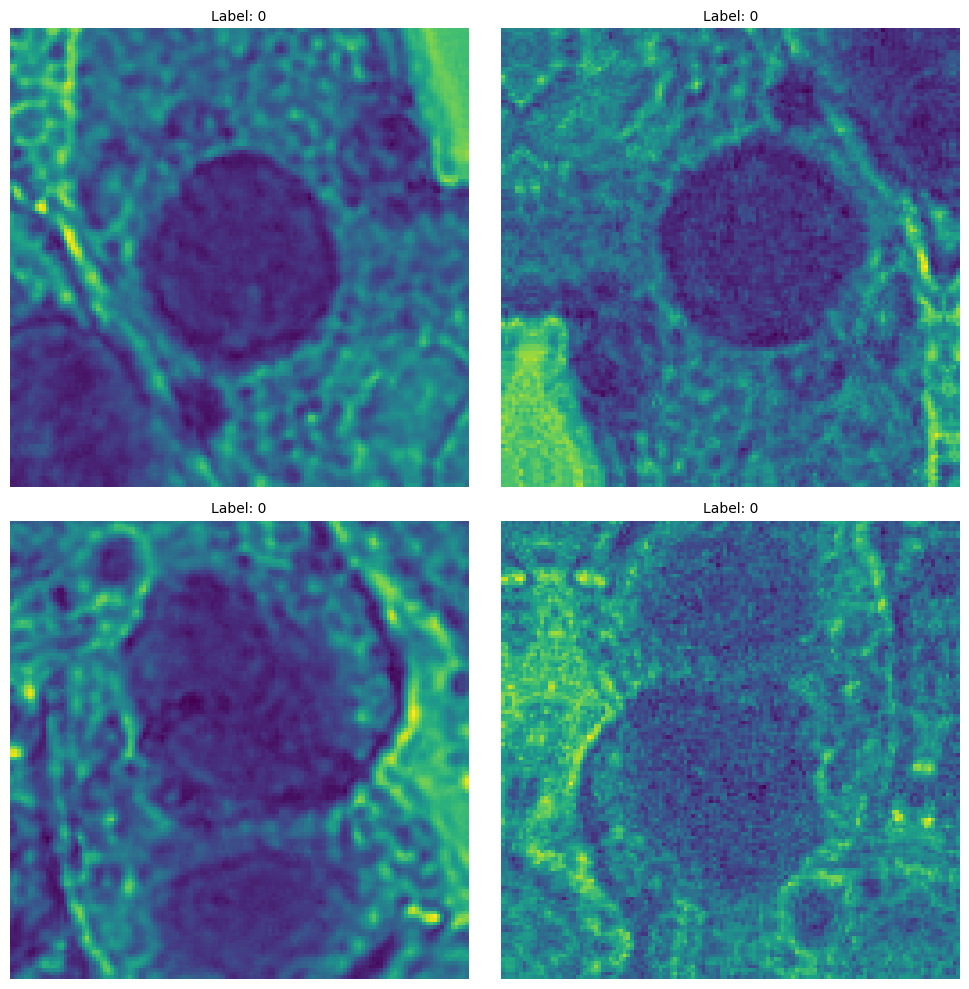

In [31]:
# plot images
train_generator = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=(SHAPE[0], SHAPE[1]),
    color_mode=COLOR_MODE,
    shuffle=False,
)



for images, labels in train_generator:
    print(images.shape)
    print(labels.shape)

    #filenames_in_batch = [train_generator.filenames[idx] for idx in train_generator.index_array]

    plt.figure(figsize=(10, 10))

    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))

        #file_name = filenames_in_batch[i]
        label = np.argmax(labels[i])
        plt.title(f"Label: {label}", fontsize=10)

        plt.axis("off")

    plt.tight_layout()
    plt.show()
    break

In [32]:
train_generator.class_names

['cells', 'not']

### Train model

Found 14000 files belonging to 2 classes.
Found 7000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6029 - loss: 0.6964 - val_accuracy: 0.8373 - val_loss: 0.4744
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7398 - loss: 0.5579 - val_accuracy: 0.8551 - val_loss: 0.3856
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7953 - loss: 0.4965 - val_accuracy: 0.8581 - val_loss: 0.3776
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8132 - loss: 0.4742 - val_accuracy: 0.8610 - val_loss: 0.3702
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8159 - loss: 0.4642 - val_accuracy: 0.8591 - val_loss: 0.3695
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8165 - loss: 0.4610 - val_accuracy: 0.8599 - val_loss: 0.3626
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8212 - loss: 0.4573 - val_accuracy: 0.8616

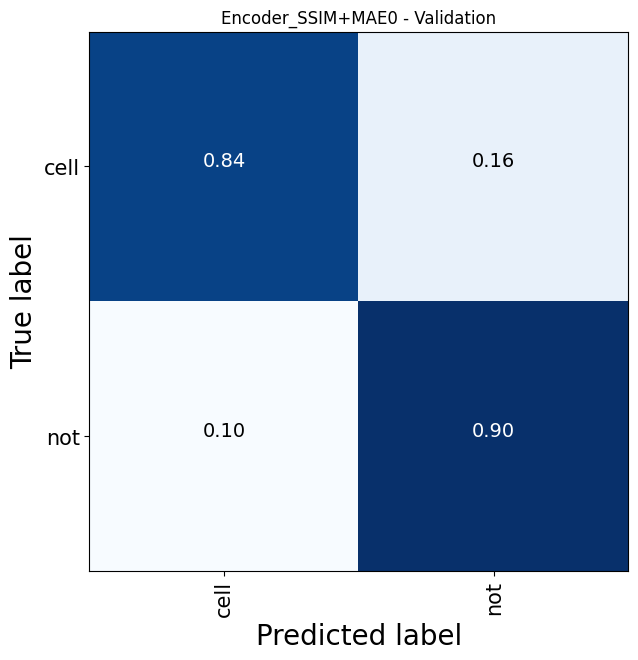

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

2025-05-03 14:18:07.779185: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

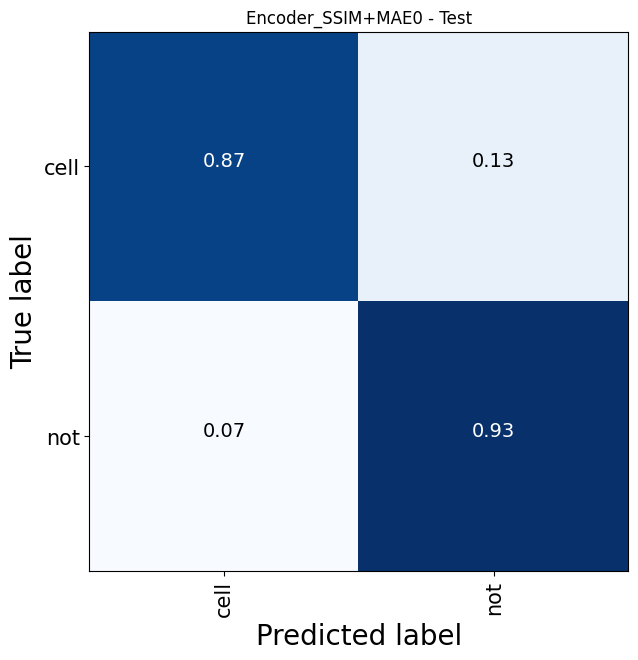

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5438 - loss: 1.2045 - val_accuracy: 0.6997 - val_loss: 0.8677
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7138 - loss: 0.8214 - val_accuracy: 0.8221 - val_loss: 0.5807
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7855 - loss: 0.6371 - val_accuracy: 0.8489 - val_loss: 0.4727
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8137 - loss: 0.5364 - val_accuracy: 0.8459 - val_loss: 0.4378
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8212 - loss: 0.4945 - val_accuracy: 0.8609 - val_loss: 0.3936
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8255 - loss: 0.4653 - val_accuracy: 0.8533 - val_loss: 0.3914
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8276 - loss: 0.4497 - val_accuracy: 0.8576 - val_loss: 0.3768
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8335 - loss: 0.4471 - val_accuracy: 0.

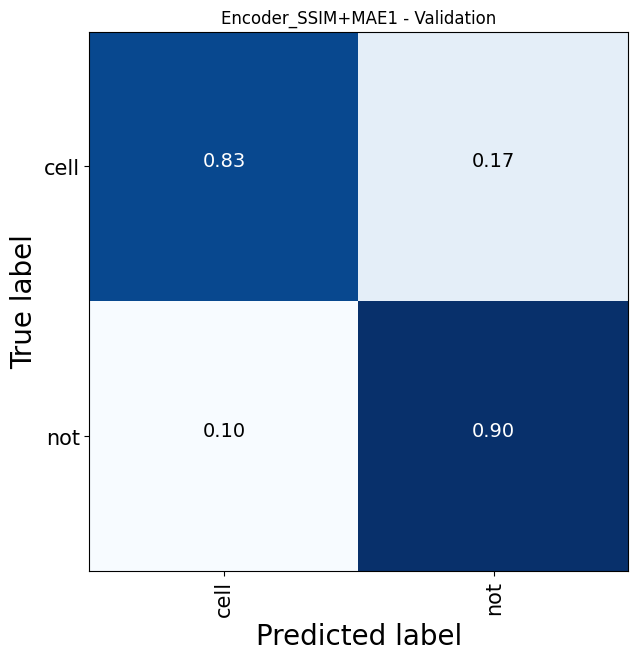

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

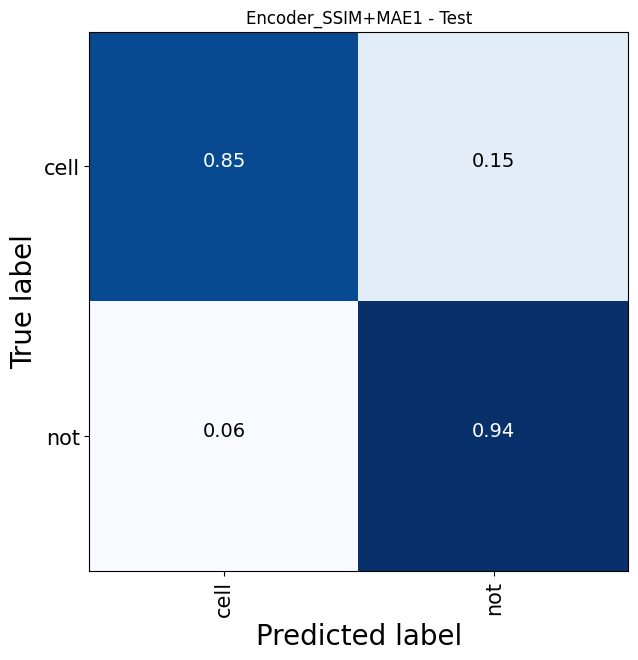

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5827 - loss: 0.7185 - val_accuracy: 0.6381 - val_loss: 0.6624
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6816 - loss: 0.6409 - val_accuracy: 0.7116 - val_loss: 0.5833
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7251 - loss: 0.5925 - val_accuracy: 0.7884 - val_loss: 0.5024
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7553 - loss: 0.5536 - val_accuracy: 0.7961 - val_loss: 0.4811
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7664 - loss: 0.5338 - val_accuracy: 0.8134 - val_loss: 0.4585
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7738 - loss: 0.5242 - val_accuracy: 0.8120 - val_loss: 0.4589
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7834 - loss: 0.5171 - val_accuracy: 0.8073 - val_loss: 0.4622
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7779 - loss: 0.5169 - val_accuracy: 0.

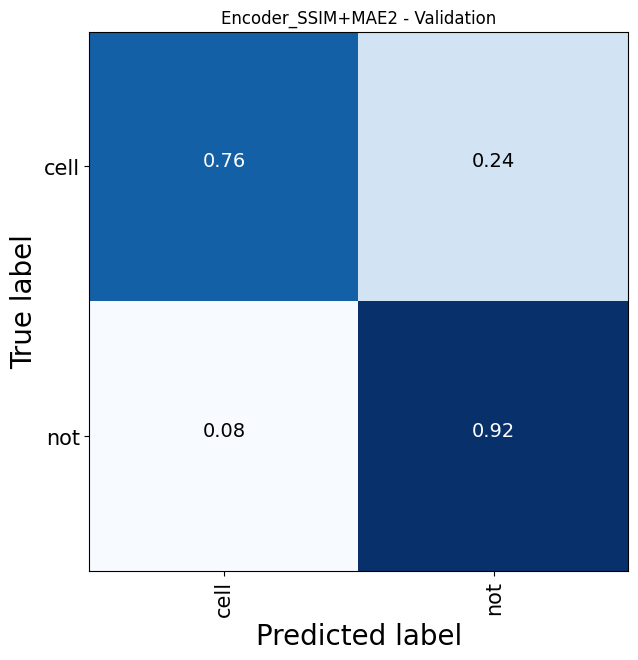

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

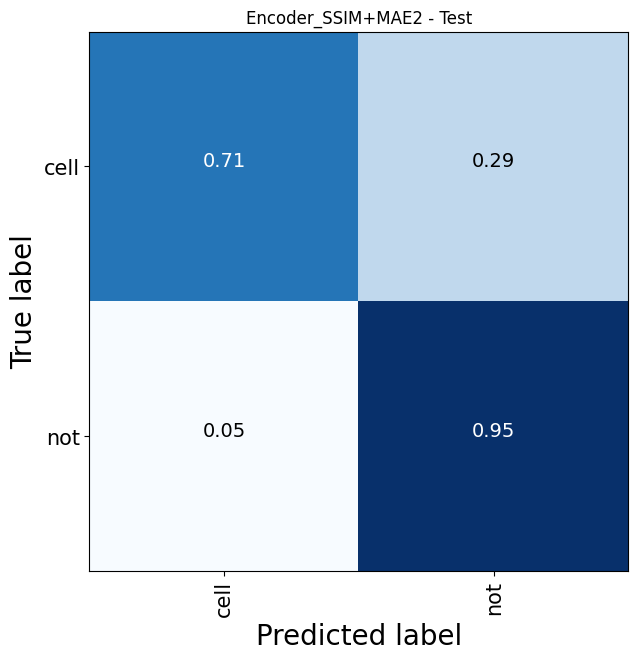

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5794 - loss: 0.9069 - val_accuracy: 0.7826 - val_loss: 0.5573
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7646 - loss: 0.5865 - val_accuracy: 0.8196 - val_loss: 0.4561
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7797 - loss: 0.5282 - val_accuracy: 0.8239 - val_loss: 0.4323
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7810 - loss: 0.5082 - val_accuracy: 0.8260 - val_loss: 0.4220
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7852 - loss: 0.5081 - val_accuracy: 0.8159 - val_loss: 0.4233
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7791 - loss: 0.5106 - val_accuracy: 0.8346 - val_loss: 0.4024
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7818 - loss: 0.5004 - val_accuracy: 0.8313 - val_loss: 0.3993
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7817 - loss: 0.5071 - val_accuracy: 0.

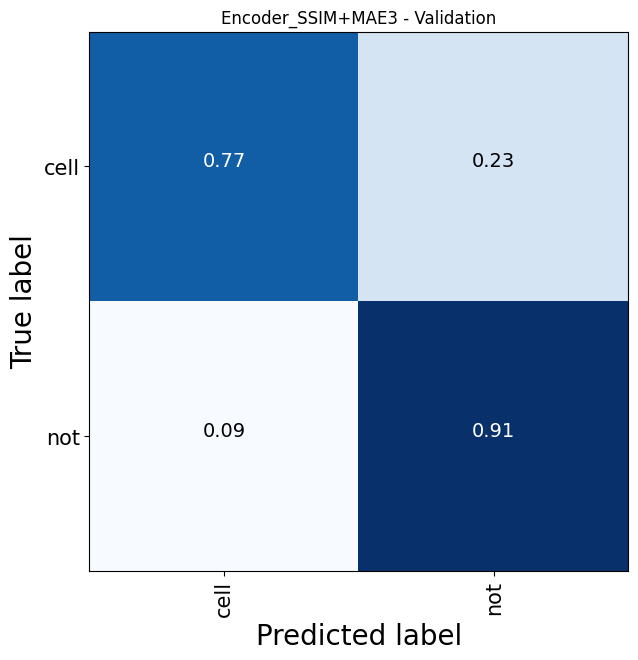

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

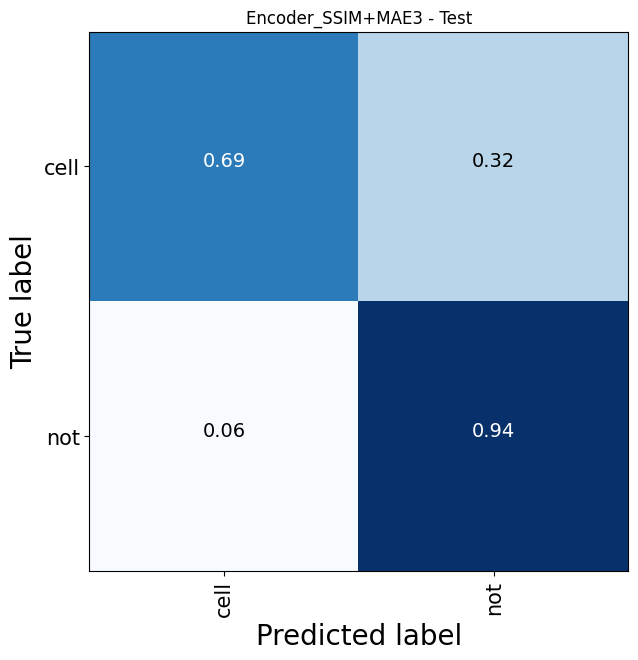

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7791 - loss: 0.5018 - val_accuracy: 0.8717 - val_loss: 0.3263
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8765 - loss: 0.3265 - val_accuracy: 0.8774 - val_loss: 0.3051
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8820 - loss: 0.3155 - val_accuracy: 0.8800 - val_loss: 0.2999
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8822 - loss: 0.3036 - val_accuracy: 0.8816 - val_loss: 0.2945
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8866 - loss: 0.2988 - val_accuracy: 0.8823 - val_loss: 0.2909
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8867 - loss: 0.2934 - val_accuracy: 0.8821 - val_loss: 0.2881
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8869 - loss: 0.2908 - val_accuracy: 0.8809 - val_loss: 0.2854
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8914 - loss: 0.2821 - val_accuracy: 0.

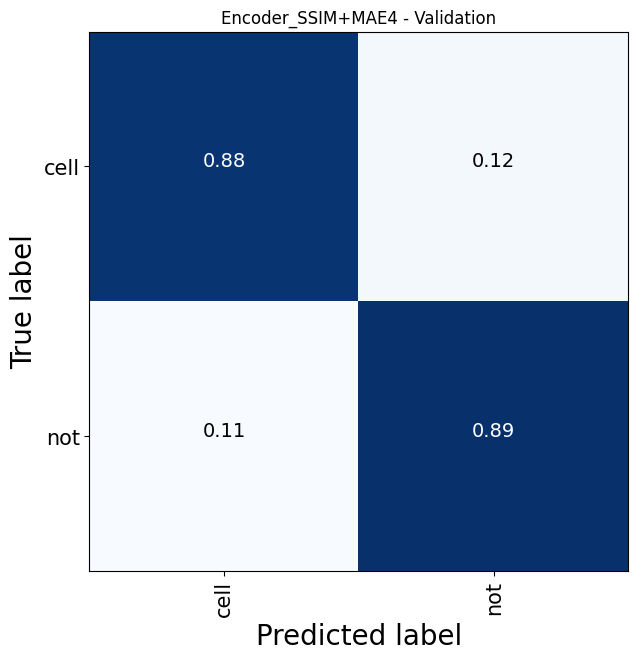

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

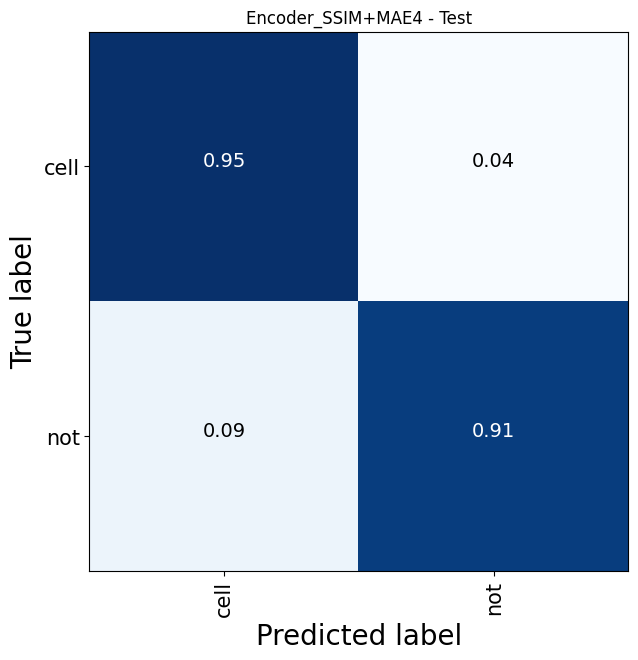

In [36]:
train_generator,validation_generator,test_generator=data_gen()
stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=2,
)

param_grid = {
    'dropout_rate': [0.3, 0.5],
    'l2_reg': [1e-3, 0.01],
}
combinations = list(product(*param_grid.values()))
combinations.append((0.0, 0.0))

for i, params in enumerate(combinations):

  encoder_name="Encoder_SSIM+MAE"+str(i)
  encoder= keras.saving.load_model(ENCODER_PATH)
  model = get_model(encoder,TRAIN_ENCODER,SHAPE,params[0],params[1])
  model.compile(keras.optimizers.Adam(
    #  1e-4
      ),
      loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
      )


  model.fit(train_generator,
          epochs=50,
          validation_data = validation_generator,
          callbacks=[ stopping],
          )
  
  os.makedirs(MODEL_PATH, exist_ok=True)
  model.save(os.path.join(MODEL_PATH, f'supervised_{encoder_name}.keras'))
  print()
  print(params)
  print()
  plot_conf_matrix(model, validation_generator, f'{encoder_name} - Validation')
  plot_conf_matrix(model, test_generator, f'{encoder_name} - Test')



In [38]:
import pandas as pd

results_df = pd.DataFrame(results)

os.makedirs(RESULTS_PATH, exist_ok=True)
results_df.to_excel(RESULT_PATH)

print(results_df)


                             Model  Accuracy    Recall  Precision  Specificity
0   Encoder_SSIM+MAE4 - Validation  0.892429  0.886857   0.896851     0.898000
1         Encoder_SSIM+MAE4 - Test  0.935500  0.948000   0.924878     0.923000
2   Encoder_SSIM+MAE4 - Validation  0.892429  0.886857   0.896851     0.898000
3         Encoder_SSIM+MAE4 - Test  0.935500  0.948000   0.924878     0.923000
4   Encoder_SSIM+MAE4 - Validation  0.892429  0.886857   0.896851     0.898000
5         Encoder_SSIM+MAE4 - Test  0.935500  0.948000   0.924878     0.923000
6   Encoder_SSIM+MAE4 - Validation  0.892429  0.886857   0.896851     0.898000
7         Encoder_SSIM+MAE4 - Test  0.935500  0.948000   0.924878     0.923000
8   Encoder_SSIM+MAE4 - Validation  0.892429  0.886857   0.896851     0.898000
9         Encoder_SSIM+MAE4 - Test  0.935500  0.948000   0.924878     0.923000
10  Encoder_SSIM+MAE0 - Validation  0.867000  0.838857   0.888889     0.895143
11        Encoder_SSIM+MAE0 - Test  0.901500  0.8700